In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms,text_removal

# 3rd Party Libraries
from skimage.io import imread
from skimage.color import rgb2gray
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import ml_metrics as metrics

In [5]:
# Load Data
data_manager = DataManager()
db, db_files = data_manager.load_data(folder = "./data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")
qsd2_w1, qsd2_w1_files = data_manager.load_data(folder = "./data/qsd2_w1/", extension = ".jpg", desc = "Loading qsd2_w1 Data...")
qsd1_w2, qsd1_w2_files = data_manager.load_data(folder = "./data/qsd1_w2/", extension = ".jpg", desc = "Loading qsd1_w2 Data...")
qsd2_w2, qsd2_w2_files = data_manager.load_data(folder = "./data/qsd2_w2/", extension = ".jpg", desc = "Loading qsd2_w2 Data...")
qst1_w2, qst2_w2_files = data_manager.load_data(folder = "./data/qst1_w2/", extension = ".jpg", desc = "Loading qst1_w2 Data...")
qst2_w2, qst2_w2_files = data_manager.load_data(folder = "./data/qst2_w2/", extension = ".jpg", desc = "Loading qst2_w2 Data...")

# Crop images
# ToDo: Implement Alex method to crop paintings (both background or multi-image querysets)
# e.g new_qst2_w2 = crop_images(qst2_w2)
# modify parameter inside calculate_histograms calculate_histograms(qst2_w2,16 to calculate_histograms(new_qst2_w2,16

#Method to remove text from the image with a rectangle 0 mask
new_qsd1_w2 = text_removal(qsd1_w2,num_images= 1,desc = 'Removing text of images') 


# 3D Normalized Histograms Multiresolutio/Block Images
db_feature_matrix = calculate_histograms(data = db, n_bins = 16, n_rows=6, n_cols=6, desc="Normalized 3D Histograms Calculation for BBDD...")
qsd2_w1_feature_matrix = calculate_histograms(data = qsd2_w1, n_bins = 16, n_rows=6, n_cols=6, desc = "Normalized 3D Histograms Calculation for qsd2_w1...")
qsd1_w2_feature_matrix = calculate_histograms(data =new_qsd1_w2, n_bins = 16, n_rows=6, n_cols=6, desc = "Normalized 3D Histograms Calculation for qsd1_w2...")
qsd2_w2_feature_matrix = calculate_histograms(data = qsd2_w2, n_bins = 16, n_rows=6, n_cols=6, desc = "Normalized 3D Histograms Calculation for qsd2_w2...")
qst1_w2_feature_matrix = calculate_histograms(data = qst1_w2, n_bins = 16, n_rows=6, n_cols=6, desc = "Normalized 3D Histograms Calculation for qst1_w2...")
qst2_w2_feature_matrix = calculate_histograms(data = qst2_w2, n_bins = 16, n_rows=6, n_cols=6, desc = "Normalized 3D Histograms Calculation for qst2_w2...")


# Reduce Cardinality using PCA
"""db_feature_matrix = data_manager.reduce_cardinality(data = db_feature_matrix)
qsd2_w1_feature_matrix = data_manager.reduce_cardinality(data = qsd2_w1_feature_matrix)
qsd1_w2_feature_matrix = data_manager.reduce_cardinality(data = qsd1_w2_feature_matrix)
qsd2_w2_feature_matrix = data_manager.reduce_cardinality(data = qsd2_w2_feature_matrix)
qst1_w2_feature_matrix = data_manager.reduce_cardinality(data = qst1_w2_feature_matrix)
qst2_w2_feature_matrix = data_manager.reduce_cardinality(data = qst2_w2_feature_matrix)"""

# Similarity
sim = Similarity()
qs2_w1_similarities = sim.compute_similarities(qs = qsd2_w1_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd2_w1 similarities...", similarity = 'hellinger')
qs1_w2_similarities = sim.compute_similarities(qs = qsd1_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd1_w2 similarities...", similarity = 'hellinger')
qs2_w2_similarities = sim.compute_similarities(qs = qsd2_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd2_w2 similarities...", similarity = 'hellinger')
qst1_w2_similarities = sim.compute_similarities(qs = qst1_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qst1_w2 similarities...", similarity = 'hellinger')
qst2_w2_similarities = sim.compute_similarities(qs = qst2_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qst2_w2 similarities...", similarity = 'hellinger')

# Get top K
top_k_qsd2_w1 = sim.get_top_k(similarity_matrix = qs2_w1_similarities, db_files = db_files, k=10, desc="Retrieving qsd2_w1 top K similar images...")
top_k_qsd1_w2 = sim.get_top_k(similarity_matrix = qs1_w2_similarities, db_files = db_files, k=10, desc="Retrieving qsd1_w2 top K similar images...")
top_k_qsd2_w2 = sim.get_top_k(similarity_matrix = qs2_w2_similarities, db_files = db_files, k=10, desc="Retrieving qsd2_w2 top K similar images...")
top_k_qst1_w2 = sim.get_top_k(similarity_matrix = qst1_w2_similarities, db_files = db_files, k=10, desc="Retrieving qst1_w2 top K similar images...")
top_k_qst2_w2 = sim.get_top_k(similarity_matrix = qst2_w2_similarities, db_files = db_files, k=10, desc="Retrieving qst2_w2 top K similar images...")

# Predict and Save
predicted_results = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week2/QST1/method1", save = True) # FOR QS WITH 1 PAINTING
#predicted_results = data_manager.save_results_2(results = top_k_qsd2_w1, path = "./week2/QST1/method1", save = True) # FOR QS WITH 1-2 PAINTINGS

# Load Truth
expected_results = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))

metric = metrics.mapk(actual = expected_results, predicted = predicted_results, k=10)
print("MAP@K Score: {:.4f}% ({}/{})".format(metric*100,int(len(predicted_results)*metric),len(predicted_results)))

Loading BBDD Data...: 100%|██████████████████████████████████████████████████████████| 287/287 [00:20<00:00, 14.13it/s]


./data/BBDD/ read: 287 images


Loading qsd1_w2 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/qsd2_w1/ read: 30 images


Loading qsd2_w2 Data...:  53%|█████████████████████████████▊                          | 16/30 [00:00<00:00, 151.35it/s]

./data/qsd1_w2/ read: 30 images


Loading qst1_w2 Data...: 100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 362.41it/s]

./data/qsd2_w2/ read: 30 images



Loading qst2_w2 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/qst1_w2/ read: 30 images


Removing text of images:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/qst2_w2/ read: 30 images


Normalized 3D Histograms Calculation for BBDD...: 100%|██████████████████████████████| 287/287 [00:04<00:00, 65.77it/s]
Normalized 3D Histograms Calculation for qsd2_w1...: 100%|████████████████████████████| 30/30 [00:00<00:00, 169.95it/s]
Normalized 3D Histograms Calculation for qsd1_w2...: 100%|████████████████████████████| 30/30 [00:00<00:00, 245.31it/s]
Normalized 3D Histograms Calculation for qsd2_w2...: 100%|█████████████████████████████| 30/30 [00:00<00:00, 86.93it/s]
Normalized 3D Histograms Calculation for qst1_w2...: 100%|████████████████████████████| 30/30 [00:00<00:00, 250.73it/s]
Normalized 3D Histograms Calculation for qst2_w2...: 100%|████████████████████████████| 30/30 [00:00<00:00, 130.63it/s]
Retrieving qst2_w2 top K similar images...: 100%|████████████████████████████████████| 30/30 [00:00<00:00, 7515.78it/s]

Results Saved!
MAP@K Score: 51.6667% (15/30)


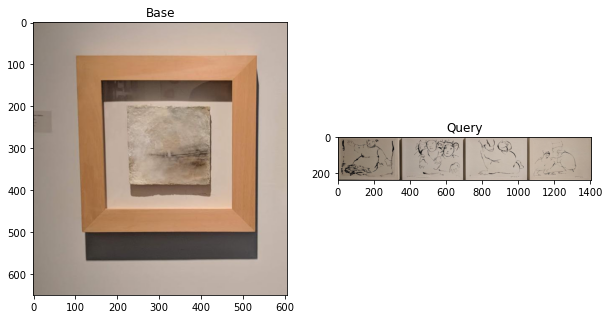

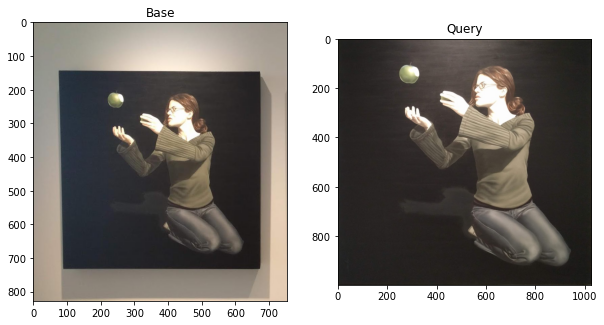

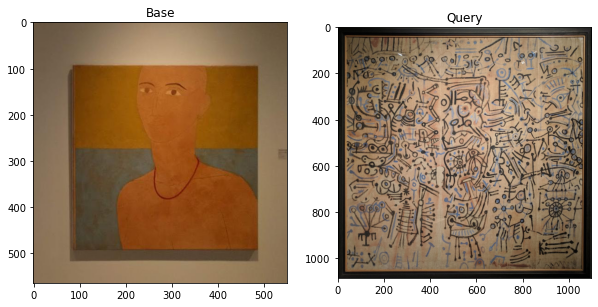

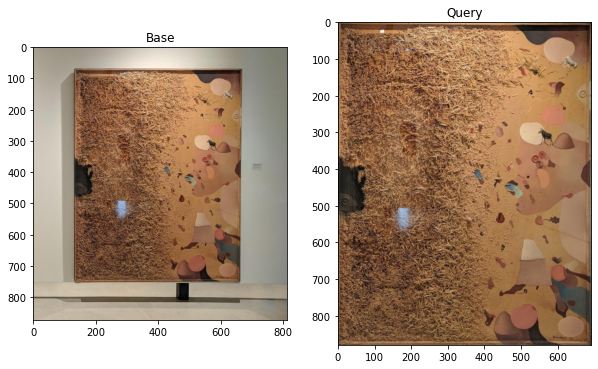

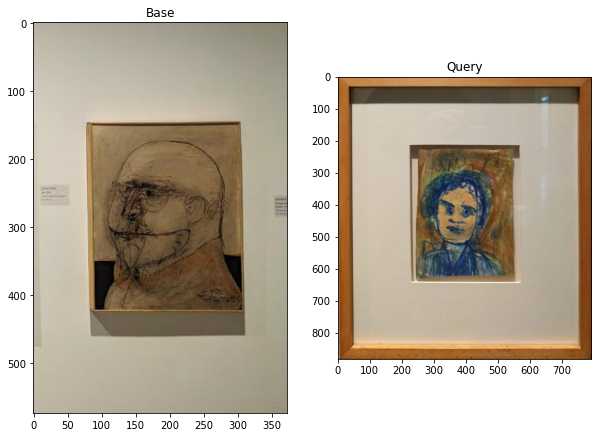

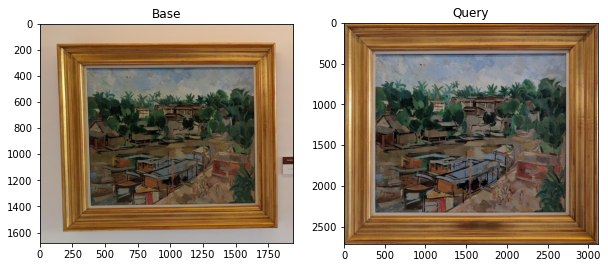

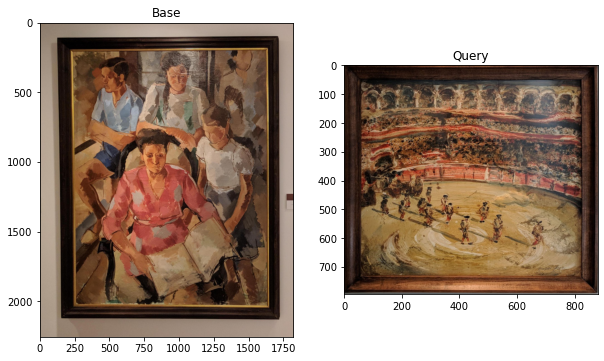

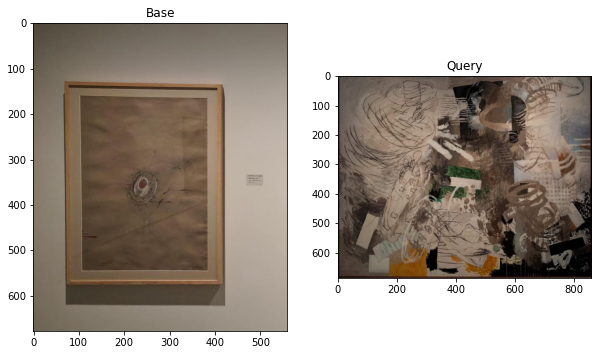

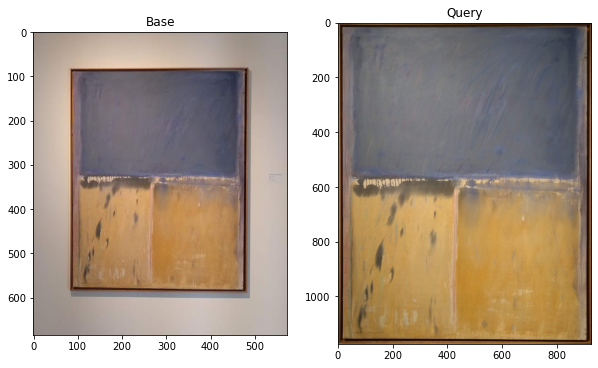

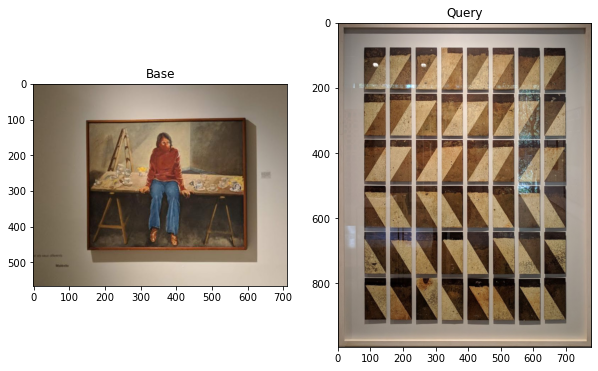

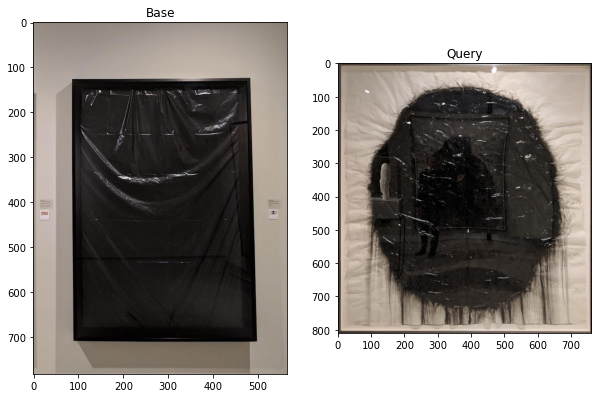

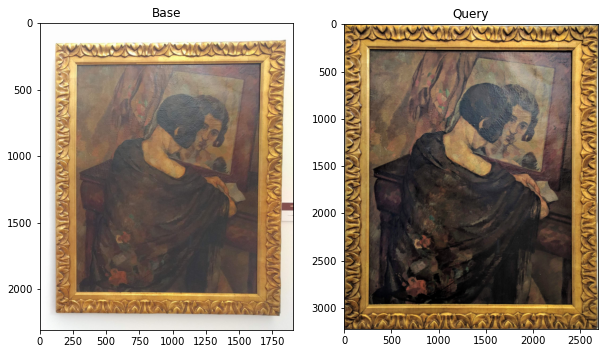

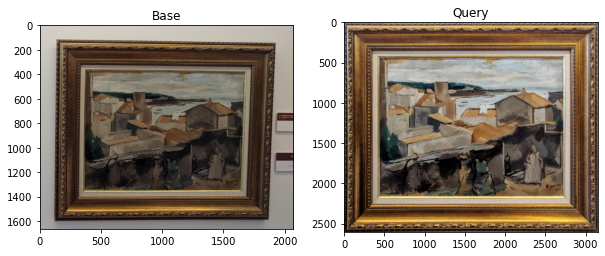

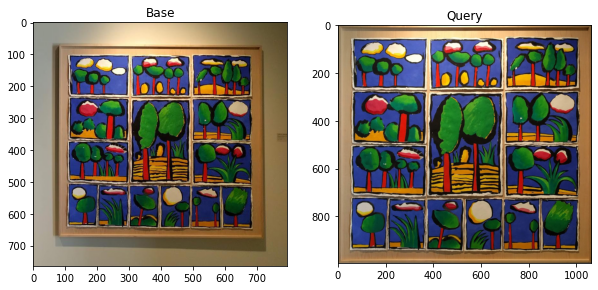

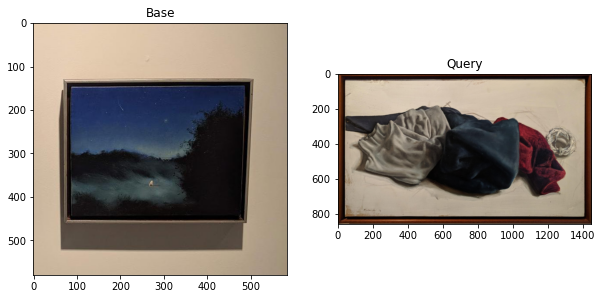

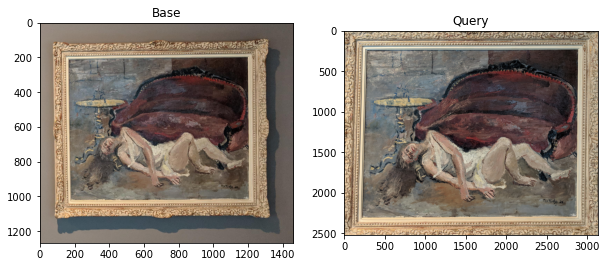

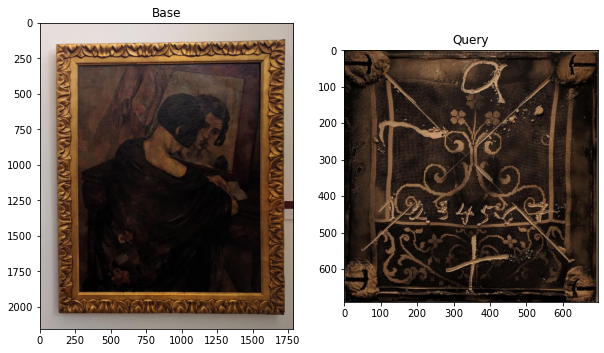

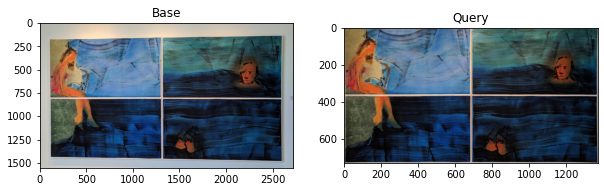

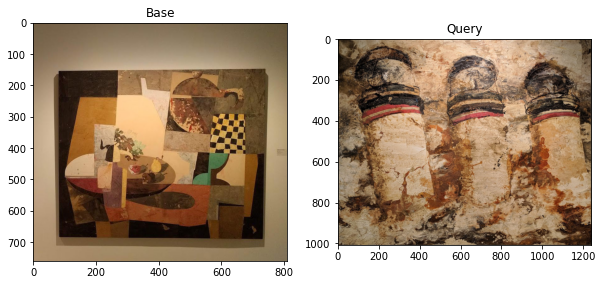

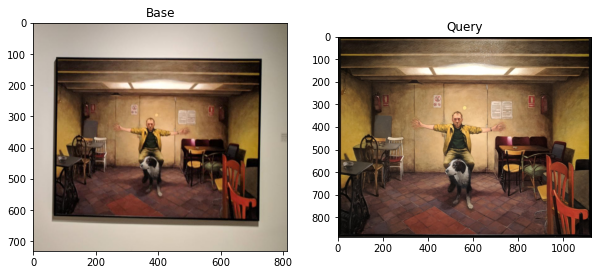

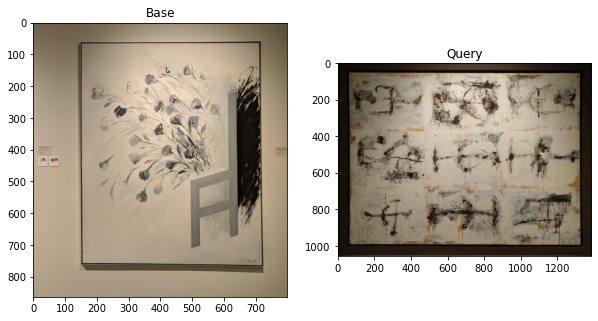

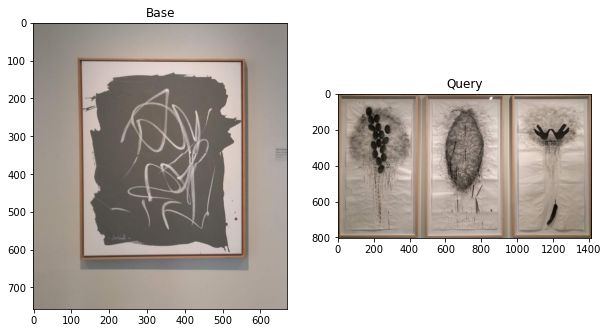

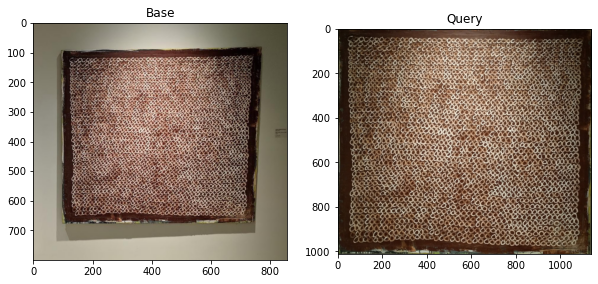

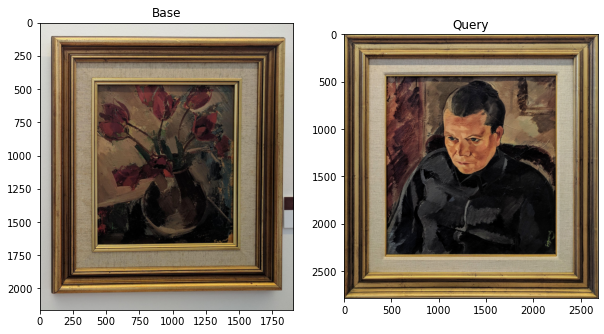

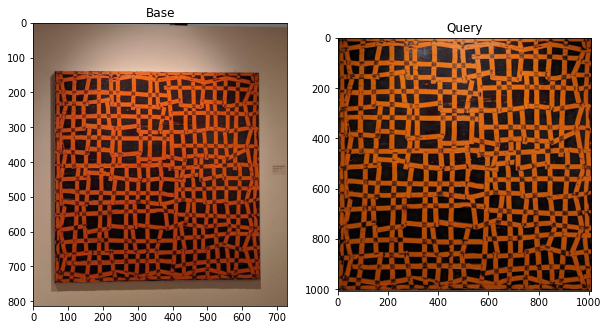

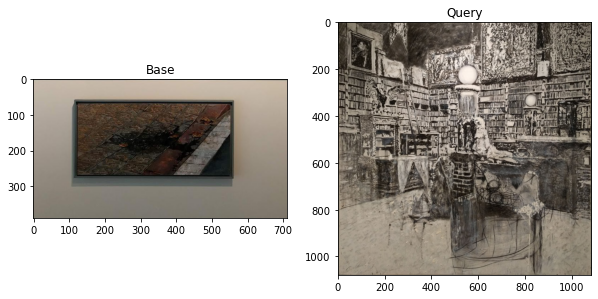

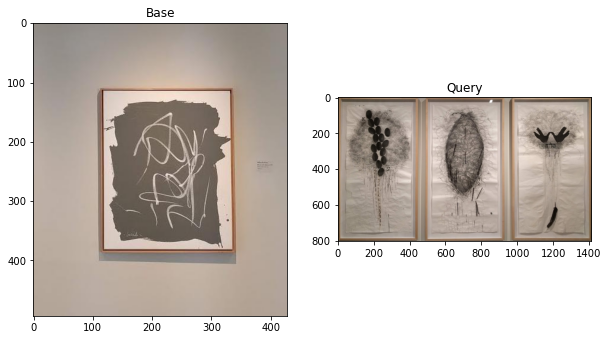

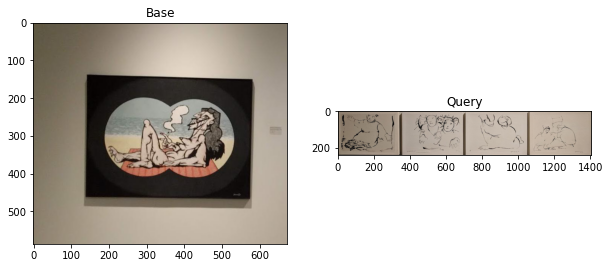

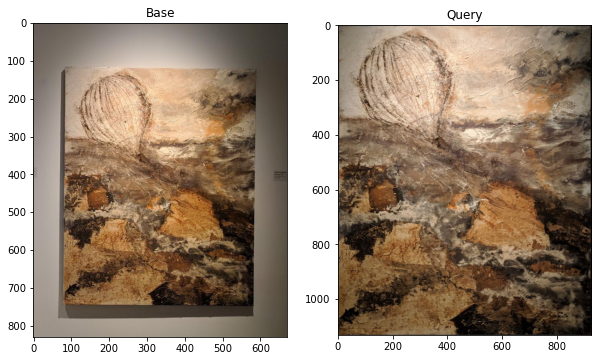

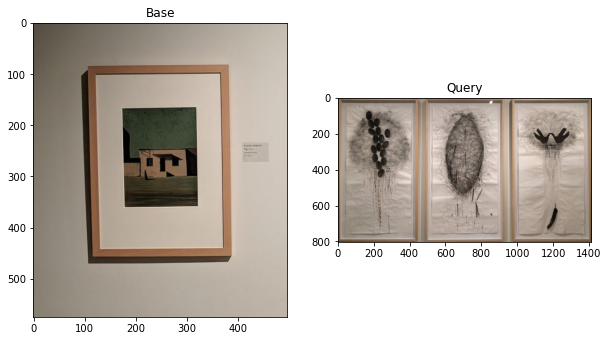

In [3]:
plot_image_and_similar(qsd2_w1,top_k_qsd2_w1)